In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Explore your Google Drive folders to locate 'Faces'
base_path = "/content/drive/MyDrive"
for root, dirs, files in os.walk(base_path):
    if "Faces" in dirs:
        print("Found Faces folder at:", os.path.join(root, "Faces"))
        break


Found Faces folder at: /content/drive/MyDrive/FACE_RECOGNISATION/Faces


In [ ]:
# Step 1: Install required libraries
!pip install -q gdown
import gdown
import pandas as pd
import os
from google.colab import drive

# Step 2: Download the CSV file using gdown
csv_id = "1sZ_FGy9XlvXjS907Kbfgek50j_cTWgwk"
csv_output = "Dataset.csv"
gdown.download(f"https://drive.google.com/uc?id={csv_id}", csv_output, quiet=False)

# Step 3: Mount Google Drive to access the shared folder with images
drive.mount('/content/drive')

# Step 4: Set the image directory path manually (change only if needed)
# NOTE: Make sure you've added the shared folder as a shortcut to *My Drive*
image_dir = "/content/drive/MyDrive/FACE_RECOGNISATION/Faces/Faces"  # adjust if the folder is nested elsewhere

# Step 5: Load CSV file and verify
df = pd.read_csv("Dataset.csv")
print("CSV Loaded:\n", df.head())

# Step 6: Verify image directory contents
print("\nSample images in folder:", os.listdir(image_dir)[:5])


Downloading...
From: https://drive.google.com/uc?id=1sZ_FGy9XlvXjS907Kbfgek50j_cTWgwk
To: /content/Dataset.csv
100%|██████████| 92.1k/92.1k [00:00<00:00, 79.9MB/s]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CSV Loaded:
                         id             label
0  Robert Downey Jr_87.jpg  Robert Downey Jr
1       Lisa Kudrow_64.jpg       Lisa Kudrow
2   Ellen Degeneres_34.jpg   Ellen Degeneres
3      Billie Eilish_3.jpg     Billie Eilish
4    Hrithik Roshan_35.jpg    Hrithik Roshan

Sample images in folder: ['Ellen Degeneres_10.jpg', 'Claire Holt_88.jpg', 'Roger Federer_44.jpg', 'Hugh Jackman_85.jpg', 'Claire Holt_54.jpg']


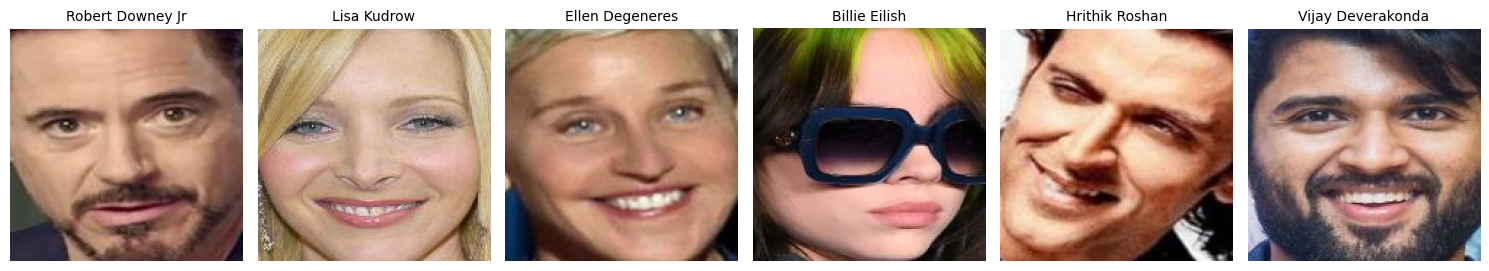

In [ ]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Step 1: Read the first 6 image file names from the CSV
sample_ids = df['id'].values[:6]

# Step 2: Plot the images
plt.figure(figsize=(15, 5))
for i, file_name in enumerate(sample_ids):
    img_path = os.path.join(image_dir, file_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(1, 6, i + 1)
        plt.imshow(img)
        plt.title(df['label'].values[i], fontsize=10)
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()


In [ ]:
from tabulate import tabulate

# Count total, train, and test images per label
total_counts = df['label'].value_counts().sort_index()
train_counts = df_train['label'].value_counts().sort_index()
test_counts = df_test['label'].value_counts().sort_index()

# Combine into a DataFrame
summary_df = pd.DataFrame({
    'Person': total_counts.index,
    'Total Images': total_counts.values,
    'Training Images': train_counts.reindex(total_counts.index, fill_value=0).values,
    'Testing Images': test_counts.reindex(total_counts.index, fill_value=0).values
})

# Print total image count in dataset
print(f"✅ Total number of images used in the model: {len(df)}")
print(f"👥 Total number of unique people in the dataset: {len(summary_df)}\n")

# Display the summary in tables with 8–10 people per table
chunk_size = 10
for i in range(0, len(summary_df), chunk_size):
    chunk = summary_df.iloc[i:i+chunk_size]
    print(f"--- People {i+1} to {min(i+chunk_size, len(summary_df))} ---")
    print(tabulate(chunk, headers='keys', tablefmt='pretty', showindex=False))
    print("\n")


✅ Total number of images used in the model: 2562
👥 Total number of unique people in the dataset: 31

--- People 1 to 10 ---
+--------------------+--------------+-----------------+----------------+
|       Person       | Total Images | Training Images | Testing Images |
+--------------------+--------------+-----------------+----------------+
|    Akshay Kumar    |      50      |       45        |       5        |
| Alexandra Daddario |      92      |       87        |       5        |
|     Alia Bhatt     |      79      |       74        |       5        |
|  Amitabh Bachchan  |      74      |       69        |       5        |
|    Andy Samberg    |      92      |       87        |       5        |
|   Anushka Sharma   |      68      |       63        |       5        |
|   Billie Eilish    |      98      |       93        |       5        |
|     Brad Pitt      |     120      |       115       |       5        |
|   Camila Cabello   |      87      |       82        |       5        |


In [ ]:
test_indices = []
train_indices = []
label_counts = defaultdict(int)

for idx, row in df.iterrows():
    label = row['label']
    if label_counts[label] < 5:
        test_indices.append(idx)
        label_counts[label] += 1
    else:
        train_indices.append(idx)

df_train = df.iloc[train_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)

In [ ]:
all_labels = sorted(df['label'].unique())
label2idx = {label: idx for idx, label in enumerate(all_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

df_train['label_idx'] = df_train['label'].map(label2idx)
df_test['label_idx'] = df_test['label'].map(label2idx)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class FaceDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id'])
        image = Image.open(img_path).convert('RGB')
        label = row['label_idx']
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# ✅ Correct this
train_dataset = FaceDataset(df_train, image_dir, transform)
test_dataset = FaceDataset(df_test, image_dir, transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(label2idx))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [ ]:


# Define layer description list
layer_descriptions = [
    ("Input", "Input Layer", "(3, 224, 224)", "-", "RGB image input"),
    ("Conv1", str(model.conv1.__class__.__name__), "(64, 112, 112)", "-", "Initial convolution layer"),
    ("BN1", str(model.bn1.__class__.__name__), "(64, 112, 112)", "-", "Batch normalization"),
    ("ReLU", str(model.relu.__class__.__name__), "(64, 112, 112)", "-", "Activation"),
    ("MaxPool", str(model.maxpool.__class__.__name__), "(64, 56, 56)", "-", "Downsampling"),
    ("Layer1", str(model.layer1.__class__.__name__), "(256, 56, 56)", "-", "First residual block group"),
    ("Layer2", str(model.layer2.__class__.__name__), "(512, 28, 28)", "-", "Second residual block group"),
    ("Layer3", str(model.layer3.__class__.__name__), "(1024, 14, 14)", "-", "Third residual block group"),
    ("Layer4", str(model.layer4.__class__.__name__), "(2048, 7, 7)", "-", "Fourth residual block group"),
    ("AvgPool", str(model.avgpool.__class__.__name__), "(2048, 1, 1)", "-", "Global average pooling"),
    ("FC", str(model.fc.__class__.__name__), f"(None, {len(label2idx)})", "-", "Final fully connected layer"),
]

# Generate markdown table
table_md = """
### 🧠 ResNet-50 Architecture Summary

| Layer Name       | Type             | Output Shape      | Param # | Description                |
|------------------|------------------|-------------------|---------|----------------------------|
"""
for name, type_, out_shape, param, desc in layer_descriptions:
    table_md += f"| {name:<16} | {type_:<16} | {out_shape:<17} | {param:<7} | {desc} |\n"

# Display markdown table
Markdown(table_md)



### 🧠 ResNet-50 Architecture Summary

| Layer Name       | Type             | Output Shape      | Param # | Description                |
|------------------|------------------|-------------------|---------|----------------------------|
| Input            | Input Layer      | (3, 224, 224)     | -       | RGB image input |
| Conv1            | Conv2d           | (64, 112, 112)    | -       | Initial convolution layer |
| BN1              | BatchNorm2d      | (64, 112, 112)    | -       | Batch normalization |
| ReLU             | ReLU             | (64, 112, 112)    | -       | Activation |
| MaxPool          | MaxPool2d        | (64, 56, 56)      | -       | Downsampling |
| Layer1           | Sequential       | (256, 56, 56)     | -       | First residual block group |
| Layer2           | Sequential       | (512, 28, 28)     | -       | Second residual block group |
| Layer3           | Sequential       | (1024, 14, 14)    | -       | Third residual block group |
| Layer4           | Sequential       | (2048, 7, 7)      | -       | Fourth residual block group |
| AvgPool          | AdaptiveAvgPool2d | (2048, 1, 1)      | -       | Global average pooling |
| FC               | Linear           | (None, 31)        | -       | Final fully connected layer |


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 149.5600
Epoch 2: Loss = 24.5133
Epoch 3: Loss = 6.2512
Epoch 4: Loss = 1.7902
Epoch 5: Loss = 1.4400
Epoch 6: Loss = 1.9781
Epoch 7: Loss = 1.1789
Epoch 8: Loss = 1.2656
Epoch 9: Loss = 0.8547
Epoch 10: Loss = 4.9307
Epoch 11: Loss = 6.6127
Epoch 12: Loss = 3.2666
Epoch 13: Loss = 1.1639
Epoch 14: Loss = 0.6169
Epoch 15: Loss = 1.0799
Epoch 16: Loss = 1.4057
Epoch 17: Loss = 1.2913
Epoch 18: Loss = 1.8329
Epoch 19: Loss = 3.2086
Epoch 20: Loss = 3.2792
Epoch 21: Loss = 3.0609
Epoch 22: Loss = 3.5040
Epoch 23: Loss = 0.9920
Epoch 24: Loss = 0.8836
Epoch 25: Loss = 0.3432
Epoch 26: Loss = 0.2112
Epoch 27: Loss = 0.5881
Epoch 28: Loss = 2.1158
Epoch 29: Loss = 0.4308
Epoch 30: Loss = 0.6662
Epoch 31: Loss = 0.3451
Epoch 32: Loss = 0.2073
Epoch 33: Loss = 0.2781
Epoch 34: Loss = 0.3024
Epoch 35: Loss = 0.4484
Epoch 36: Loss = 0.2182
Epoch 37: Loss = 0.3762
Epoch 38: Loss = 0.7149
Epoch 39: Loss = 3.5867
Epoch 40: Loss = 5.5389
Epoch 41: Loss = 3.7838
Epoch 42: Loss = 1.021

In [ ]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels_list.extend(labels.cpu().tolist())

print(f"\n🎯 Accuracy on test set (5 ảnh mỗi nhãn): {correct}/{total} = {100 * correct / total:.2f}%")


🎯 Accuracy on test set (5 ảnh mỗi nhãn): 152/155 = 98.06%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import seaborn as sns
import numpy as np



📄 Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       1.00      1.00      1.00         5
Alexandra Daddario       1.00      1.00      1.00         5
        Alia Bhatt       1.00      1.00      1.00         5
  Amitabh Bachchan       1.00      1.00      1.00         5
      Andy Samberg       0.83      1.00      0.91         5
    Anushka Sharma       1.00      1.00      1.00         5
     Billie Eilish       1.00      1.00      1.00         5
         Brad Pitt       1.00      1.00      1.00         5
    Camila Cabello       1.00      1.00      1.00         5
   Charlize Theron       1.00      1.00      1.00         5
       Claire Holt       1.00      1.00      1.00         5
      Courtney Cox       1.00      1.00      1.00         5
    Dwayne Johnson       1.00      1.00      1.00         5
   Elizabeth Olsen       1.00      1.00      1.00         5
   Ellen Degeneres       1.00      1.00      1.00         5
      Henry C

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


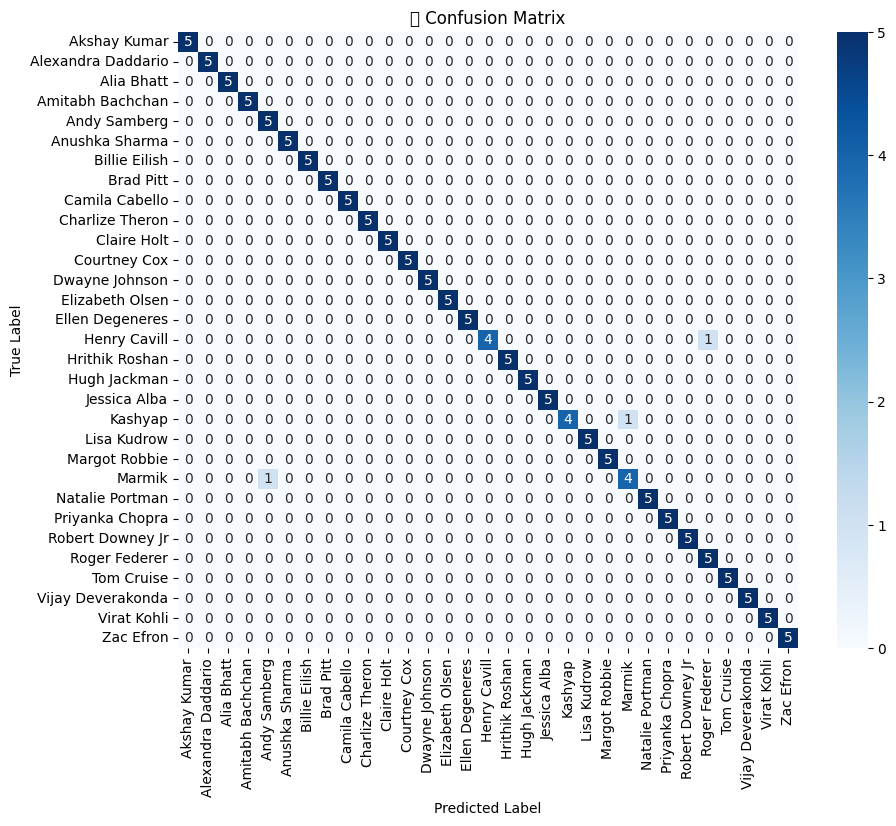


⚠️ ROC Curve is only shown for binary classification.


In [ ]:
# 🔹 Classification Report
print("\n📄 Classification Report:")
print(classification_report(all_labels_list, all_preds, target_names=[idx2label[i] for i in range(len(idx2label))]))

# 🔹 Confusion Matrix
cm = confusion_matrix(all_labels_list, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=idx2label.values(), yticklabels=idx2label.values(), cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('📌 Confusion Matrix')
plt.show()

# 🔹 ROC Curve (only works properly if binary classification)
if len(label2idx) == 2:
    # Compute probabilities instead of just labels
    with torch.no_grad():
        all_probs = []
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Take probability for class 1
            all_probs.extend(probs.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels_list, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("🔍 ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("\n⚠️ ROC Curve is only shown for binary classification.")


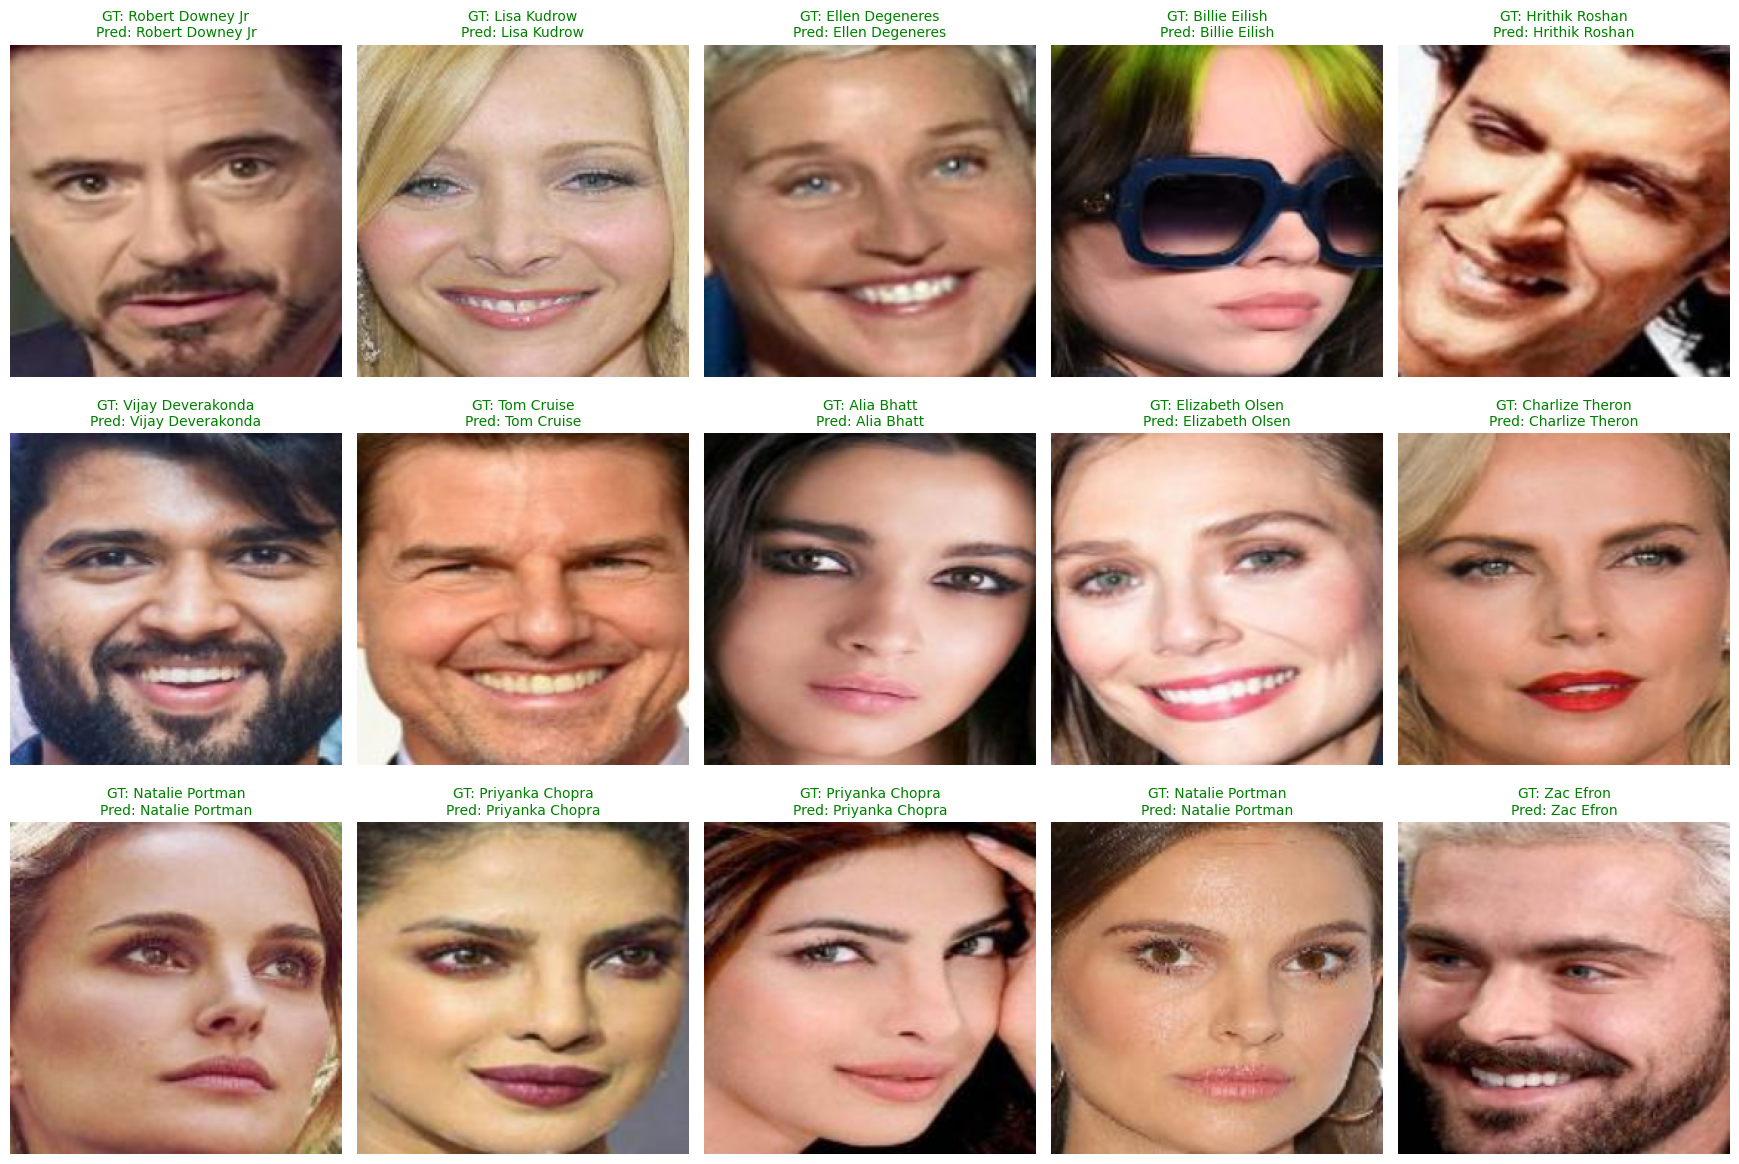

In [ ]:
import matplotlib.pyplot as plt

# Load a batch of test images (increase batch size to show more predictions)
test_images, test_labels = next(iter(DataLoader(test_dataset, batch_size=15)))  # Adjust as needed
test_images = test_images.to(device)

# Get predictions
with torch.no_grad():
    test_outputs = model(test_images)
    test_preds = torch.argmax(test_outputs, dim=1)

# Plot predictions with colored titles
batch_size = test_images.shape[0]
cols = 5  # ✅ 5 images per row
rows = (batch_size + cols - 1) // cols
plt.figure(figsize=(3.5 * cols, 4 * rows))  # ✅ Smaller figure size

for i in range(batch_size):
    img = test_images[i].cpu().permute(1, 2, 0).numpy()
    gt = idx2label[test_labels[i].item()]
    pd = idx2label[test_preds[i].item()]
    correct = gt == pd
    title_color = 'green' if correct else 'red'

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"GT: {gt}\nPred: {pd}", fontsize=10, color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()


***vgg16***

In [ ]:
from torchvision import models
import torch.nn as nn
from IPython.display import Markdown
import torch

# 1. Load VGG16 and customize classifier
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(label2idx))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.9MB/s]


In [ ]:
layer_descriptions = [
    ("Input", "Input Layer", "(3, 224, 224)", "-", "RGB image input"),
    ("Conv1_1", "Conv2d", "(64, 224, 224)", "-", "3x3 conv"),
    ("Conv1_2", "Conv2d", "(64, 224, 224)", "-", "3x3 conv"),
    ("MaxPool1", "MaxPool2d", "(64, 112, 112)", "-", "2x2 max pool"),
    ("Conv2_1", "Conv2d", "(128, 112, 112)", "-", "3x3 conv"),
    ("Conv2_2", "Conv2d", "(128, 112, 112)", "-", "3x3 conv"),
    ("MaxPool2", "MaxPool2d", "(128, 56, 56)", "-", "2x2 max pool"),
    ("Conv3_1", "Conv2d", "(256, 56, 56)", "-", "3x3 conv"),
    ("Conv3_2", "Conv2d", "(256, 56, 56)", "-", "3x3 conv"),
    ("Conv3_3", "Conv2d", "(256, 56, 56)", "-", "3x3 conv"),
    ("MaxPool3", "MaxPool2d", "(256, 28, 28)", "-", "2x2 max pool"),
    ("Conv4_1", "Conv2d", "(512, 28, 28)", "-", "3x3 conv"),
    ("Conv4_2", "Conv2d", "(512, 28, 28)", "-", "3x3 conv"),
    ("Conv4_3", "Conv2d", "(512, 28, 28)", "-", "3x3 conv"),
    ("MaxPool4", "MaxPool2d", "(512, 14, 14)", "-", "2x2 max pool"),
    ("Conv5_1", "Conv2d", "(512, 14, 14)", "-", "3x3 conv"),
    ("Conv5_2", "Conv2d", "(512, 14, 14)", "-", "3x3 conv"),
    ("Conv5_3", "Conv2d", "(512, 14, 14)", "-", "3x3 conv"),
    ("MaxPool5", "MaxPool2d", "(512, 7, 7)", "-", "2x2 max pool"),
    ("Flatten", "Flatten", "(25088,)", "-", "Flatten to vector"),
    ("FC1", "Linear", "(4096,)", "-", "Fully connected layer"),
    ("ReLU1", "ReLU", "(4096,)", "-", "Activation"),
    ("Dropout1", "Dropout", "(4096,)", "-", "Regularization"),
    ("FC2", "Linear", "(4096,)", "-", "Fully connected layer"),
    ("ReLU2", "ReLU", "(4096,)", "-", "Activation"),
    ("Dropout2", "Dropout", "(4096,)", "-", "Regularization"),
    ("Classifier", "Linear", f"(None, {len(label2idx)})", "-", "Output layer"),
]

# 3. Generate markdown table
table_md = """
### 🧠 VGG16 Architecture Summary

| Layer Name       | Type        | Output Shape      | Param # | Description             |
|------------------|-------------|-------------------|---------|-------------------------|
"""
for name, type_, out_shape, param, desc in layer_descriptions:
    table_md += f"| {name:<16} | {type_:<11} | {out_shape:<17} | {param:<7} | {desc} |\n"

# 4. Display the summary
Markdown(table_md)


### 🧠 VGG16 Architecture Summary

| Layer Name       | Type        | Output Shape      | Param # | Description             |
|------------------|-------------|-------------------|---------|-------------------------|
| Input            | Input Layer | (3, 224, 224)     | -       | RGB image input |
| Conv1_1          | Conv2d      | (64, 224, 224)    | -       | 3x3 conv |
| Conv1_2          | Conv2d      | (64, 224, 224)    | -       | 3x3 conv |
| MaxPool1         | MaxPool2d   | (64, 112, 112)    | -       | 2x2 max pool |
| Conv2_1          | Conv2d      | (128, 112, 112)   | -       | 3x3 conv |
| Conv2_2          | Conv2d      | (128, 112, 112)   | -       | 3x3 conv |
| MaxPool2         | MaxPool2d   | (128, 56, 56)     | -       | 2x2 max pool |
| Conv3_1          | Conv2d      | (256, 56, 56)     | -       | 3x3 conv |
| Conv3_2          | Conv2d      | (256, 56, 56)     | -       | 3x3 conv |
| Conv3_3          | Conv2d      | (256, 56, 56)     | -       | 3x3 conv |
| MaxPool3         | MaxPool2d   | (256, 28, 28)     | -       | 2x2 max pool |
| Conv4_1          | Conv2d      | (512, 28, 28)     | -       | 3x3 conv |
| Conv4_2          | Conv2d      | (512, 28, 28)     | -       | 3x3 conv |
| Conv4_3          | Conv2d      | (512, 28, 28)     | -       | 3x3 conv |
| MaxPool4         | MaxPool2d   | (512, 14, 14)     | -       | 2x2 max pool |
| Conv5_1          | Conv2d      | (512, 14, 14)     | -       | 3x3 conv |
| Conv5_2          | Conv2d      | (512, 14, 14)     | -       | 3x3 conv |
| Conv5_3          | Conv2d      | (512, 14, 14)     | -       | 3x3 conv |
| MaxPool5         | MaxPool2d   | (512, 7, 7)       | -       | 2x2 max pool |
| Flatten          | Flatten     | (25088,)          | -       | Flatten to vector |
| FC1              | Linear      | (4096,)           | -       | Fully connected layer |
| ReLU1            | ReLU        | (4096,)           | -       | Activation |
| Dropout1         | Dropout     | (4096,)           | -       | Regularization |
| FC2              | Linear      | (4096,)           | -       | Fully connected layer |
| ReLU2            | ReLU        | (4096,)           | -       | Activation |
| Dropout2         | Dropout     | (4096,)           | -       | Regularization |
| Classifier       | Linear      | (None, 31)        | -       | Output layer |


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm

for epoch in range(50):
    model.train()
    total_loss = 0
    for step, (images, labels) in enumerate(tqdm(train_loader)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")


100%|██████████| 76/76 [00:48<00:00,  1.55it/s]


Epoch 1: Loss = 192.1068


100%|██████████| 76/76 [00:47<00:00,  1.59it/s]


Epoch 2: Loss = 85.5163


100%|██████████| 76/76 [00:48<00:00,  1.56it/s]


Epoch 3: Loss = 35.3975


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 4: Loss = 16.5039


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 5: Loss = 11.5087


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 6: Loss = 14.0623


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 7: Loss = 3.9215


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 8: Loss = 7.1172


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 9: Loss = 2.2454


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 10: Loss = 5.2704


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 11: Loss = 2.4245


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 12: Loss = 1.6673


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 13: Loss = 6.7775


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 14: Loss = 2.8702


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 15: Loss = 0.0751


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 16: Loss = 0.2373


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 17: Loss = 2.2099


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 18: Loss = 5.8809


100%|██████████| 76/76 [00:48<00:00,  1.58it/s]


Epoch 19: Loss = 4.3497


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 20: Loss = 0.6098


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 21: Loss = 3.1517


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 22: Loss = 7.3664


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 23: Loss = 2.8602


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 24: Loss = 1.1066


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 25: Loss = 1.2035


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 26: Loss = 0.3814


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 27: Loss = 0.0502


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 28: Loss = 0.0164


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 29: Loss = 0.0044


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 30: Loss = 0.0136


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 31: Loss = 0.0074


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 32: Loss = 0.0013


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 33: Loss = 0.0029


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 34: Loss = 0.0044


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 35: Loss = 0.0008


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 36: Loss = 0.0009


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 37: Loss = 0.0006


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 38: Loss = 0.0006


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 39: Loss = 0.0011


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 40: Loss = 0.0003


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 41: Loss = 0.0008


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 42: Loss = 0.0005


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 43: Loss = 0.0002


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 44: Loss = 0.0006


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 45: Loss = 0.0004


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 46: Loss = 0.0003


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 47: Loss = 0.0003


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 48: Loss = 0.0002


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]


Epoch 49: Loss = 0.0003


100%|██████████| 76/76 [00:48<00:00,  1.57it/s]

Epoch 50: Loss = 0.0002


In [ ]:
from tqdm import tqdm

model.eval()
correct = 0
total = 0
all_preds = []
all_labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels_list.extend(labels.cpu().tolist())

accuracy = 100 * correct / total
print(f"\n🎯 Accuracy on test set: {correct}/{total} = {accuracy:.2f}%")


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


🎯 Accuracy on test set: 148/155 = 95.48%



📄 Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       0.80      0.80      0.80         5
Alexandra Daddario       1.00      1.00      1.00         5
        Alia Bhatt       1.00      1.00      1.00         5
  Amitabh Bachchan       1.00      1.00      1.00         5
      Andy Samberg       0.83      1.00      0.91         5
    Anushka Sharma       0.83      1.00      0.91         5
     Billie Eilish       1.00      1.00      1.00         5
         Brad Pitt       1.00      1.00      1.00         5
    Camila Cabello       1.00      1.00      1.00         5
   Charlize Theron       0.80      0.80      0.80         5
       Claire Holt       0.83      1.00      0.91         5
      Courtney Cox       1.00      1.00      1.00         5
    Dwayne Johnson       1.00      1.00      1.00         5
   Elizabeth Olsen       1.00      0.80      0.89         5
   Ellen Degeneres       1.00      1.00      1.00         5
      Henry C

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


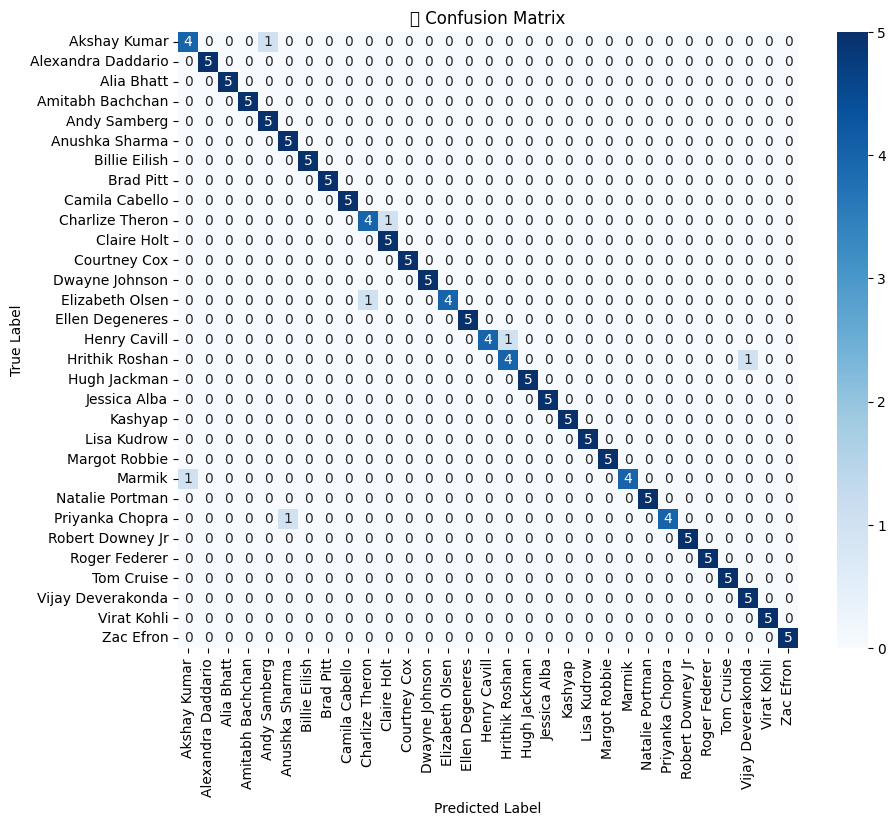

In [ ]:
print("\n📄 Classification Report:")
print(classification_report(all_labels_list, all_preds, target_names=[idx2label[i] for i in range(len(idx2label))]))

cm = confusion_matrix(all_labels_list, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=idx2label.values(), yticklabels=idx2label.values(), cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('📌 Confusion Matrix')
plt.show()


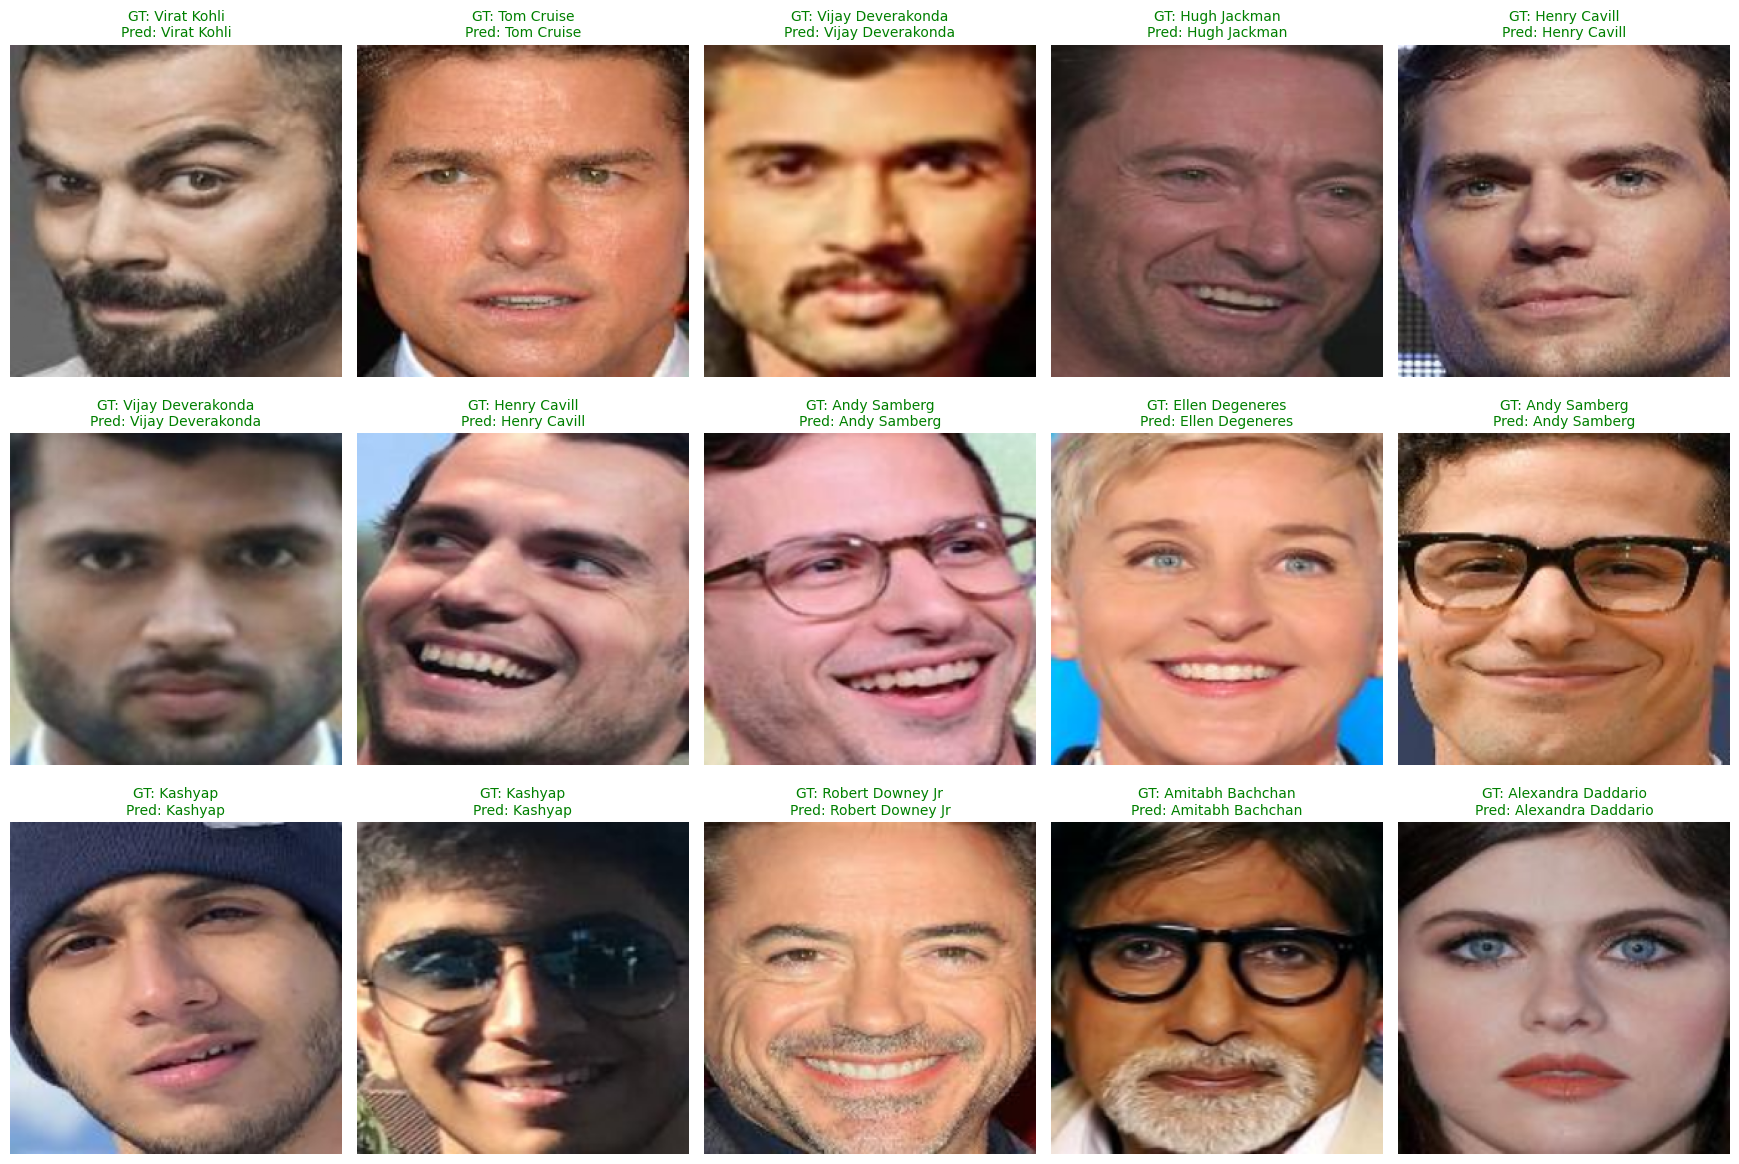

In [ ]:
import random
from torch.utils.data import Subset

# Select 15 random indices from the test set
random_indices = random.sample(range(len(test_dataset)), 15)
random_subset = Subset(test_dataset, random_indices)

# Create a DataLoader for this random subset
random_loader = DataLoader(random_subset, batch_size=15, shuffle=False)

# Get the batch
test_images, test_labels = next(iter(random_loader))
test_images = test_images.to(device)

# Predict
with torch.no_grad():
    test_outputs = model(test_images)
    test_preds = torch.argmax(test_outputs, dim=1)

# Plot
batch_size = test_images.shape[0]
cols = 5
rows = (batch_size + cols - 1) // cols
plt.figure(figsize=(3.5 * cols, 4 * rows))

for i in range(batch_size):
    img = test_images[i].cpu().permute(1, 2, 0).numpy()
    gt = idx2label[test_labels[i].item()]
    pd = idx2label[test_preds[i].item()]
    correct = gt == pd
    title_color = 'green' if correct else 'red'

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"GT: {gt}\nPred: {pd}", fontsize=10, color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()


***DenseNet-121***

In [ ]:
from torchvision import models
import torch.nn as nn
from IPython.display import Markdown
import torch

# 1. Load model and customize final classifier
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, len(label2idx))
model = model.to(device)

# 2. Extract key blocks
layer_descriptions = [
    ("Input", "Input Layer", "(3, 224, 224)", "-", "RGB image input"),
    ("Conv1", str(model.features.conv0.__class__.__name__), "-", "-", "Initial convolution layer"),
    ("Norm1", str(model.features.norm0.__class__.__name__), "-", "-", "Batch normalization"),
    ("ReLU", str(model.features.relu0.__class__.__name__), "-", "-", "Activation"),
    ("MaxPool", str(model.features.pool0.__class__.__name__), "-", "-", "Downsampling"),
    ("Dense Block 1", str(model.features.denseblock1.__class__.__name__), "-", "-", "First Dense Block"),
    ("Transition 1", str(model.features.transition1.__class__.__name__), "-", "-", "Transition Layer"),
    ("Dense Block 2", str(model.features.denseblock2.__class__.__name__), "-", "-", "Second Dense Block"),
    ("Transition 2", str(model.features.transition2.__class__.__name__), "-", "-", "Transition Layer"),
    ("Dense Block 3", str(model.features.denseblock3.__class__.__name__), "-", "-", "Third Dense Block"),
    ("Transition 3", str(model.features.transition3.__class__.__name__), "-", "-", "Transition Layer"),
    ("Dense Block 4", str(model.features.denseblock4.__class__.__name__), "-", "-", "Fourth Dense Block"),
    ("Classifier", str(model.classifier.__class__.__name__), f"(None, {len(label2idx)})", "-", "Final Fully Connected Layer"),
]

# 3. Generate markdown table
table_md = """
### 🧠 DenseNet121 Architecture Summary

| Layer Name       | Type             | Output Shape      | Param # | Description                |
|------------------|------------------|-------------------|---------|----------------------------|
"""
for name, type_, out_shape, param, desc in layer_descriptions:
    table_md += f"| {name:<16} | {type_:<16} | {out_shape:<17} | {param:<7} | {desc} |\n"

# 4. Display the summary
Markdown(table_md)



### 🧠 DenseNet121 Architecture Summary

| Layer Name       | Type             | Output Shape      | Param # | Description                |
|------------------|------------------|-------------------|---------|----------------------------|
| Input            | Input Layer      | (3, 224, 224)     | -       | RGB image input |
| Conv1            | Conv2d           | -                 | -       | Initial convolution layer |
| Norm1            | BatchNorm2d      | -                 | -       | Batch normalization |
| ReLU             | ReLU             | -                 | -       | Activation |
| MaxPool          | MaxPool2d        | -                 | -       | Downsampling |
| Dense Block 1    | _DenseBlock      | -                 | -       | First Dense Block |
| Transition 1     | _Transition      | -                 | -       | Transition Layer |
| Dense Block 2    | _DenseBlock      | -                 | -       | Second Dense Block |
| Transition 2     | _Transition      | -                 | -       | Transition Layer |
| Dense Block 3    | _DenseBlock      | -                 | -       | Third Dense Block |
| Transition 3     | _Transition      | -                 | -       | Transition Layer |
| Dense Block 4    | _DenseBlock      | -                 | -       | Fourth Dense Block |
| Classifier       | Linear           | (None, 31)        | -       | Final Fully Connected Layer |


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(50):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 189.7444
Epoch 2: Loss = 73.4910
Epoch 3: Loss = 26.5531
Epoch 4: Loss = 9.8133
Epoch 5: Loss = 5.1182
Epoch 6: Loss = 3.0368
Epoch 7: Loss = 2.2046
Epoch 8: Loss = 1.6181
Epoch 9: Loss = 1.2718
Epoch 10: Loss = 1.1715
Epoch 11: Loss = 0.9712
Epoch 12: Loss = 2.5377
Epoch 13: Loss = 1.4519
Epoch 14: Loss = 1.8040
Epoch 15: Loss = 1.5312
Epoch 16: Loss = 0.5784
Epoch 17: Loss = 0.5254
Epoch 18: Loss = 0.6783
Epoch 19: Loss = 0.4384
Epoch 20: Loss = 0.8492
Epoch 21: Loss = 1.1320
Epoch 22: Loss = 0.5671
Epoch 23: Loss = 0.3426
Epoch 24: Loss = 0.2444
Epoch 25: Loss = 0.1916
Epoch 26: Loss = 0.1951
Epoch 27: Loss = 0.2400
Epoch 28: Loss = 0.3242
Epoch 29: Loss = 0.2708
Epoch 30: Loss = 0.2272
Epoch 31: Loss = 2.1278
Epoch 32: Loss = 4.1920
Epoch 33: Loss = 0.8656
Epoch 34: Loss = 0.2599
Epoch 35: Loss = 0.2508
Epoch 36: Loss = 0.1258
Epoch 37: Loss = 0.3472
Epoch 38: Loss = 1.6725
Epoch 39: Loss = 1.7609
Epoch 40: Loss = 0.3826
Epoch 41: Loss = 0.1647
Epoch 42: Loss = 0.60

In [ ]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().tolist())
        all_labels_list.extend(labels.cpu().tolist())

print(f"\n🎯 Accuracy on test set : {correct}/{total} = {100 * correct / total:.2f}%")



🎯 Accuracy on test set : 154/155 = 99.35%



📄 Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       1.00      1.00      1.00         5
Alexandra Daddario       1.00      1.00      1.00         5
        Alia Bhatt       1.00      1.00      1.00         5
  Amitabh Bachchan       1.00      1.00      1.00         5
      Andy Samberg       1.00      1.00      1.00         5
    Anushka Sharma       1.00      1.00      1.00         5
     Billie Eilish       1.00      1.00      1.00         5
         Brad Pitt       1.00      1.00      1.00         5
    Camila Cabello       1.00      1.00      1.00         5
   Charlize Theron       1.00      0.80      0.89         5
       Claire Holt       1.00      1.00      1.00         5
      Courtney Cox       1.00      1.00      1.00         5
    Dwayne Johnson       1.00      1.00      1.00         5
   Elizabeth Olsen       1.00      1.00      1.00         5
   Ellen Degeneres       1.00      1.00      1.00         5
      Henry C

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


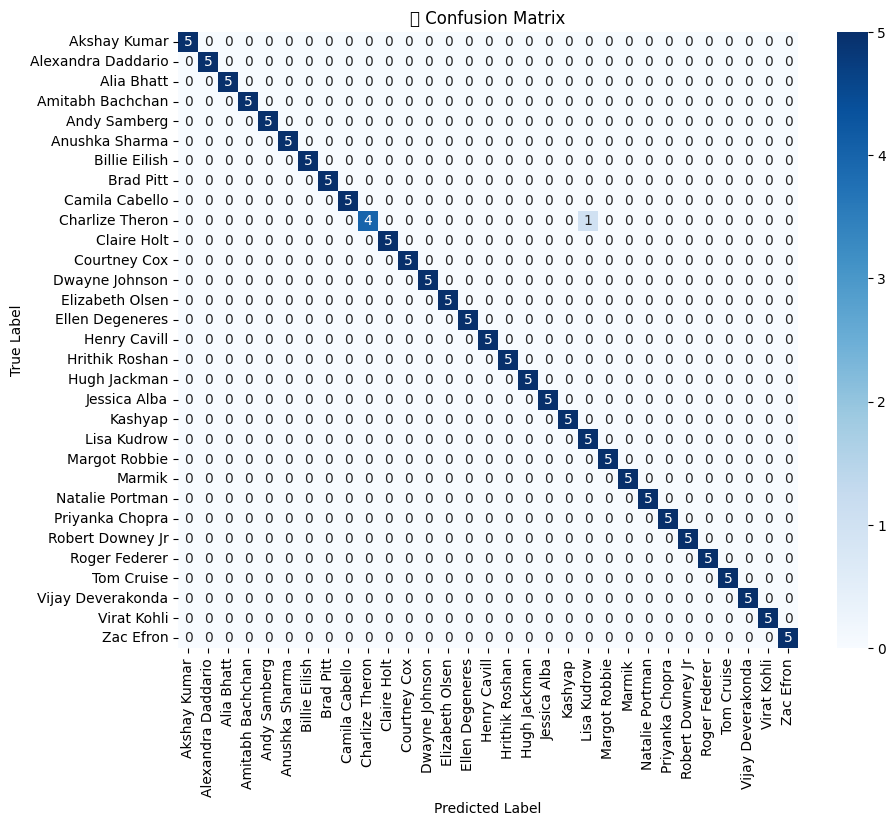

In [ ]:
print("\n📄 Classification Report:")
print(classification_report(all_labels_list, all_preds, target_names=[idx2label[i] for i in range(len(idx2label))]))

cm = confusion_matrix(all_labels_list, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=idx2label.values(), yticklabels=idx2label.values(), cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('📌 Confusion Matrix')
plt.show()


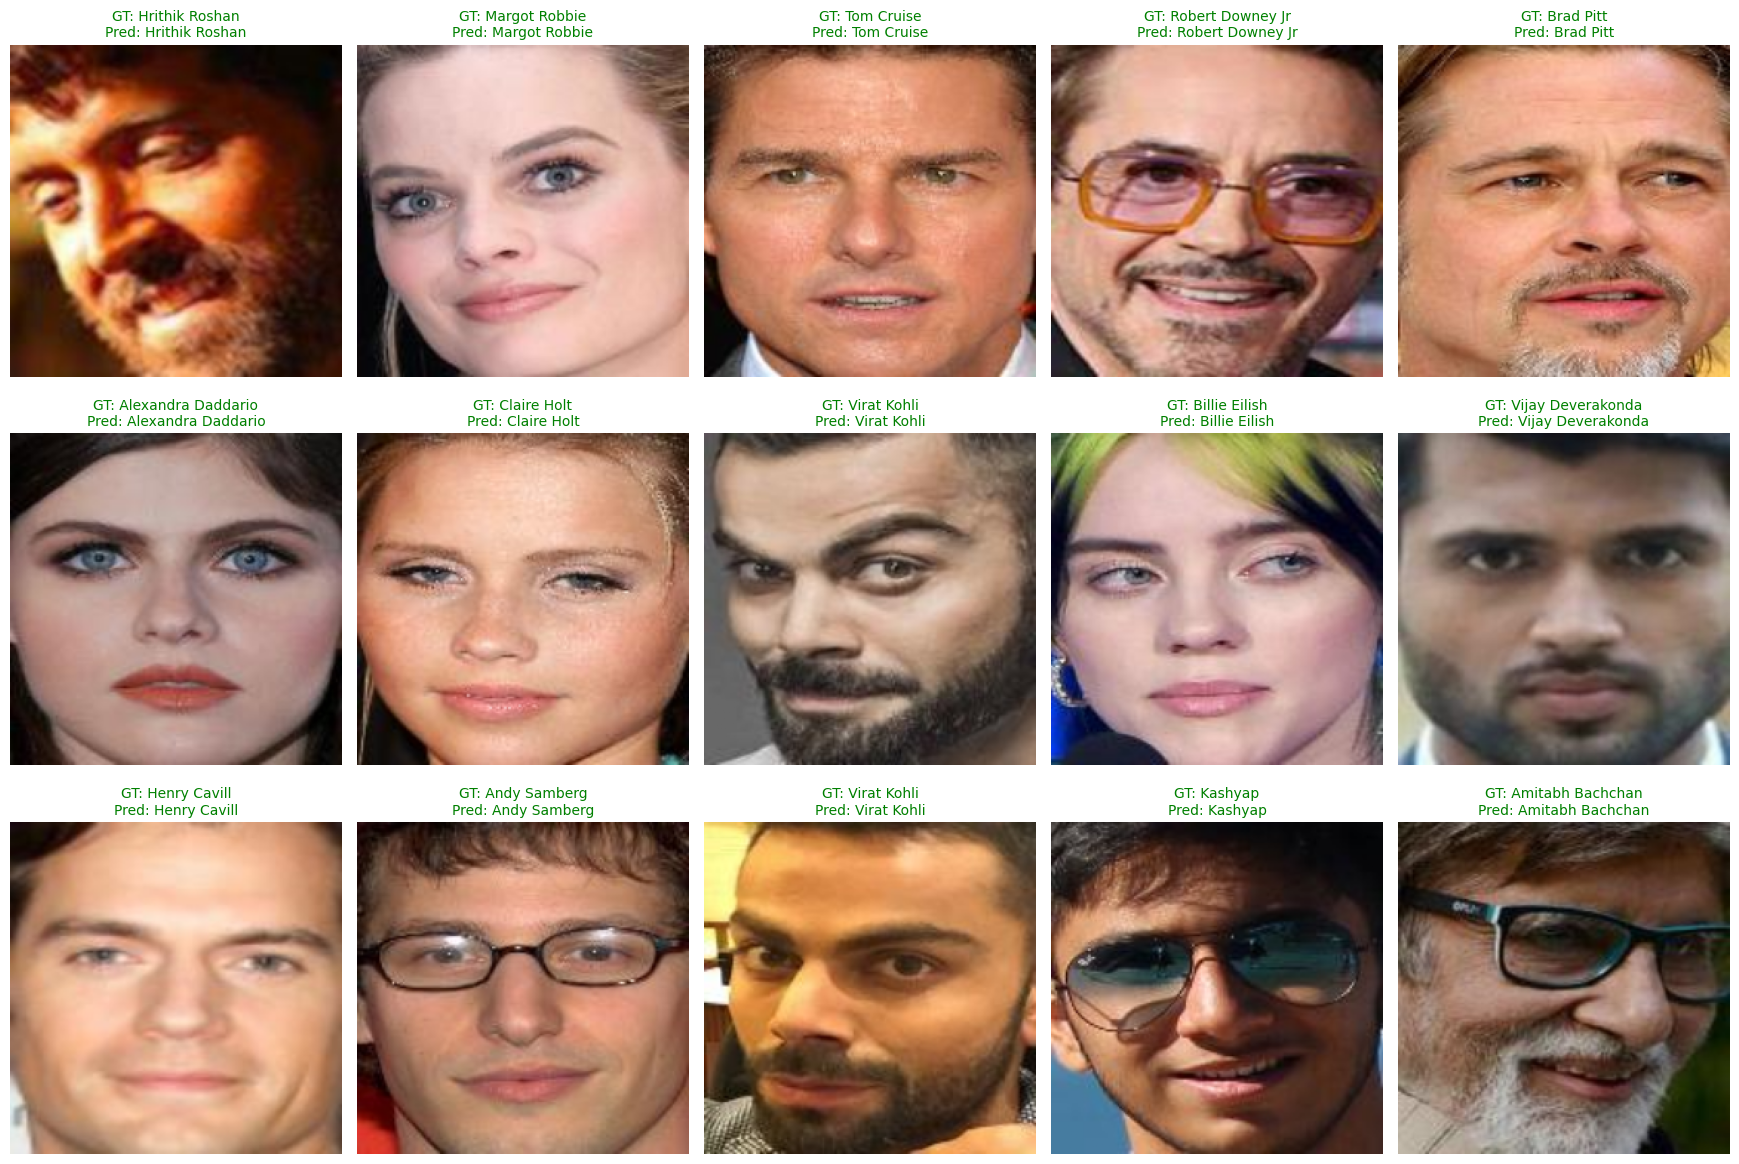

In [ ]:
import random
from torch.utils.data import Subset

# Select 15 random indices from the test set
random_indices = random.sample(range(len(test_dataset)), 15)
random_subset = Subset(test_dataset, random_indices)

# Create a DataLoader for this random subset
random_loader = DataLoader(random_subset, batch_size=15, shuffle=False)

# Get the batch
test_images, test_labels = next(iter(random_loader))
test_images = test_images.to(device)

# Predict
with torch.no_grad():
    test_outputs = model(test_images)
    test_preds = torch.argmax(test_outputs, dim=1)

# Plot
batch_size = test_images.shape[0]
cols = 5
rows = (batch_size + cols - 1) // cols
plt.figure(figsize=(3.5 * cols, 4 * rows))

for i in range(batch_size):
    img = test_images[i].cpu().permute(1, 2, 0).numpy()
    gt = idx2label[test_labels[i].item()]
    pd = idx2label[test_preds[i].item()]
    correct = gt == pd
    title_color = 'green' if correct else 'red'

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"GT: {gt}\nPred: {pd}", fontsize=10, color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()
